#### Version's detail (pour qu'on s'y retrouve)
V2 : Able to parse over wiki page info and turn into csv doc. Strugles with special character and disambiguation pages. Citations counts are weird

V2.1 : Solved the special character problem

V2.2 : Cleaned the table and formated the date. Added a little hist to view page creation along time

V2.3 : Adding a function to pass the 500 treshhold in scraping articles title

V2.4 : Adding the scraping of the titles of sub- and sub-sub-sections

In [2]:
!pip install wikipedia setuptools pywikibot mwparserfromhell pandas numpy scipy nltk tqdm seaborn pyqt5 pyqtwebengine ruamel-yaml lxml

In [1]:
import wikipedia
import re
import pywikibot
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.request import urlopen
import json


In [2]:
wikipedia.set_lang("en")  #We make our research in english

#### definition of the function for the CORPUS SELECTION

In [15]:
def function_to_get_all_the_bloody_titles(key_words : str)-> (list[str],int):
    ''' 
    
    '''
    titles = []
    a = key_words.lower().replace(' ', '+')
    scraped_url = 'https://en.wikipedia.org/w/index.php?title=Special:Search&limit=5000&offset=0&profile=default&search={}&ns0=1'.format(a)
    html_text = requests.get(scraped_url).text
    soup = BeautifulSoup(html_text, 'lxml')
    r = soup.find('div', {'class' : 'results-info'})
    nbr_result = int(r.get('data-mw-num-results-total'))
    for interest in soup.find_all('div', {'class' : 'mw-search-result-heading'}):
        titles.append(interest.find('a')['title'])
    return titles, nbr_result

In [10]:
def get_section_titles(page : str) -> list[str]:
    '''
    Returns the section titles

    :param page: Title of the page
    :return: The list of section titles
    '''
    section_tit = set()
    section_title = []
    scraped_url = wikipedia.page(page, auto_suggest = False).url
    html_text = requests.get(scraped_url).text
    soup = BeautifulSoup(html_text, 'lxml')
    r = soup.find_all('h2') + soup.find_all('h3') + soup.find_all('h4')
    for i in r:
        if i.find('span', {'class' : 'mw-headline'}) is not None:
            section_tit.add(i.find('span', {'class' : 'mw-headline'})['id'])
    for i in section_tit:
        section_title.append(i.replace('_', ' '))        
    return section_title

In [12]:
#We define a function to automatically set up a corpus of related articles
def corpus_selection(word_keys : str , number_of_results : int, key_for_section : str) -> list[str]:
    '''
    Select the corpus if the keywords are in the section or in the title

    :param word_keys : string 
    
    :return: a dictionnary containing the title of all the pages of the corpus
    '''
    corpus = []
    proper_list = []
    left_list = []
    function = function_to_get_all_the_bloody_titles(word_keys)
    nbr_result = function[1]
    search_list = function[0] #Select and put in a list number_of_results wikipedia articles related to word_keys
    
    for article in tqdm(search_list):
        try:
            wikipedia.summary(article, auto_suggest = False)
            proper_list.append(article)
        except wikipedia.exceptions.DisambiguationError as e:
            pass
        except wikipedia.exceptions.PageError as e:
            try:
                wikipedia.summary(article, auto_suggest = False)
                proper_list.append(article)
            except wikipedia.exceptions.PageError as e:
                pass
    
    for proper_article in tqdm(proper_list):
        if key_for_section in proper_article.lower(): #Among these articles, select the ones whose title contains key_for_selection for the corpus
            corpus.append(proper_article)
        else:
            left_list.append(proper_article) #Put the rest of the articles in a list
            
    for left_article in tqdm(left_list):
        sec_tit = []
        try :
            sec_tit = get_section_titles(left_article)
            for section in sec_tit:
                if key_for_section.lower() in section.lower() and left_article not in corpus:
                    corpus.append(left_article)
        except wikipedia.exceptions.DisambiguationError as e:
            pass
        except wikipedia.exceptions.PageError as e:
            try:
                sec_tit = get_section_titles(left_article)
                for section in sec_tit:
                    if key_for_section.lower() in section.lower() and left_article not in corpus:
                        corpus.append(left_article)
            except wikipedia.exceptions.PageError as e:
                pass

    return corpus[:number_of_results]

## TO LAUNCH THE CORPUS SELECTION

In [16]:
%%time
search_list = corpus_selection("Effects of climate change",5000, 'climate change')


100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]

Wall time: 1.01 s


In [17]:
len(search_list)

10

In [18]:
search_list=["Effects of climate change"]

### Get the information on the protected articles of the corpus

In [19]:
def protection_status(data):
    
    years_off = []
    for i in range(22):
        years_off.append(2001+i)
    
    wrong_ones = []
    dot = pd.DataFrame(years_off)
    
    for article in data:
        
        html_text = requests.get(('https://en.wikipedia.org/wiki/Special:Log?type=protect&user=&page={}&wpdate=&tagfilter=&subtype=').format(article)).text
        soup = BeautifulSoup(html_text, 'lxml')
        dic = {}
        results = soup.find_all('li', {'class' : 'mw-logline-protect'})
        
        for i in results:
            z = i.find('a')
            protection = i.get('data-mw-logaction')
            date = str(z)[str(z).find('Log">') + 5:str(z).find('</a>')]
            dic[pd.to_datetime(date, format = '%H:%M, %d %B %Y')] = protection
        
        if 'expires' in str(results):
            res = str(results).split('span')
            for string in res:
                if '] (expires' in string:
                    date_get = string[string.find('] (expires ') + 11:string.find(' (UTC))')]
                    if ') [' in date_get:
                        date_get = date_get[:date_get.find(') [')]
                    if '] (' in date_get:
                        date_get = date_get[date_get.find(', '):]
                    if ')' in date_get:
                        date_get = date_get.replace(')', '')
                    if date_get[:2] == ', ':
                        date_get = date_get[2:]
                    if date_get[-1] == ' ':
                        date_get = date_get[:-1]
                    if ',' in date_get:
                        date_get = date_get.replace(',', '')
                    try:
                        dic[pd.to_datetime(date_get, format = '%H:%M %d %B %Y')] = 'protect/unprotect'
                    except:
                        try:
                            dic[pd.to_datetime(date_get, format = '%H:%M %B %d %Y')] = 'protect/unprotect'
                        except:
                            wrong_ones.append(article)

        if len(dic) != 0:
            dic = dict(sorted(dic.items()))
            new_dic = {}
            s = set()
            list_date = list(dic.keys())[::-1]
            for date in list_date:
                s.add(date.year)
            for j in sorted(s):
                deadline = pd.to_datetime('30 June {} 00:00:00'.format(j))
                same_year = []
                for date in list_date:
                    if date.year == deadline.year and date <= deadline:
                        same_year.append(date)
                        if len(same_year) != 0:
                            new_dic[deadline.year] = dic[max(same_year)]
                    else :
                        if date.year == deadline.year and date > pd.to_datetime('30 June {}'.format(max(s))):
                            new_dic[max(s) + 1] = dic[max(list_date)]

            keys = list(new_dic.keys())
            for year in years_off:
                if year < min(keys):
                    new_dic[year] = 'protect/unprotect'
                elif year > max(keys):
                    new_dic[year] = new_dic[max(keys)]
                else:
                    for low in keys:
                        for high in keys:
                            if year > low and year < high and len(keys[keys.index(low):keys.index(high)]) == 1:
                                new_dic[year] = new_dic[low]
                                
            d = dict(sorted(new_dic.items()))
            
            if len(d) == 22:
                dot[article] = d.values()
            else:
                dot[article] = list(d.values())[:22]
        
    return dot

In [20]:
protection_status_evolution = protection_status(search_list)

#### creation of the dataframe

In [21]:
%%time
def crea_dataframe(search_list : list,keyword : str)-> pd.DataFrame:
    '''
    param search_list: liste containing the name of all the articles
    param keyword: string containing the keyword that we want to scrap
    
    
    return: data frame containg the name, the url and the wikicode of the entire page if the keyword is in the title.
    If it's not it returns the wiki code of the section containing the keyword only. Or return the wikicode for each entire page if the line with recode are commented
    '''
    tableau =[] #creation of a list that will contain a dictionnary for each page with the information
    
    
    #this part is if you only want to scrap the citations for the functions
    #It detects if the keyword is included in a section, a subsection or a subsubsection
    #if the aim is to plot only the section then just remove the ''' '''
    '''
    recode= r'(?:==(?:\w|\ )*?(?:'+keyword[0].lower()+'|'+keyword[0].upper()+')'+keyword[1:]+'(?:\w|\ )*?==\n)((?:.|\n)*?)(?:==(?:\w|\ )*==\n)'
    recode2=r'(?:===(?:\w|\ )*?(?:'+keyword[0].lower()+'|'+keyword[0].upper()+')'+keyword[1:]+'(?:\w|\ )*?===\n)((?:.|\n)*?)(?:(?:===|==)(?:\w|\ )*(?:===|==)\n)'
    recode3=r'(?:====(?:\w|\ )*?(?:'+keyword[0].lower()+'|'+keyword[0].upper()+')'+keyword[1:]+'(?:\w|\ )*?====\n)((?:.|\n)*?)(?:(?:===|==|====)(?:\w|\ )*(?:===|==|====)\n)'
    '''
    #browse all the titles  of the search list
    for i in tqdm(range(len(search_list))):
             
        #find the wikipedia page
        page =wikipedia.page(search_list[i], auto_suggest = False)
        page_title =page.title #give the clean name of the page
        page_url=page.url #give the url of the page
        site = pywikibot.Site("en", "wikipedia")
        page = pywikibot.Page(site, page_title)
        
        #if you want to scrap for only the section containing the keywordremove the next line and '''  '''
        page_text=page.text
                
        '''
        if keyword.lower() in page_title.lower(): 
            page_text=page.text
        else:
            page_text = str(re.findall(recode , page.text))
        if page_text=="[]":
            page_text = str(re.findall(recode2, page.text))
        if page_text== "[]":
            page_text = str(re.findall(recode3, page.text))
        '''
            
        infopage ={'Name only' : page_title, 'page url' :page_url,'text':page_text}
        tableau.append(infopage)
    df=pd.DataFrame.from_dict(tableau)
    return df


df=crea_dataframe(search_list,"climate change")
df

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.01s/it]

Wall time: 2.03 s


,Name only,page url,text
0,Effects of climate change,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|Effects created by climate...


#### definition of the function for the extraction of citation

In [22]:
# Some additional functions
def get_ids_from_ref(ref: str)-> dict:
    '''
    detects if the reference entering this program contains a doi or a pmid or a pmc and if it's the case the return it 
    Also returns the name of the journal in which the article has been published
    
    param ref : the string of a reference
    
    return ids:  a dictionnary containing the doi or pmid or pmc and the journal of the reference if it's a scientific reference
    '''
    
    d = dict(re.findall(r'(doi|pmc|pmid)(?:(?:\s?[=\|]\s?)|(?:\.)|(?:(?:])*?:)|(?:\s|\/)|(?: *=))([^|\s}]*)', ref))
    if d!={}:
        recode=re.findall(r'(journal of (?:\w| )*)',ref)+re.findall(r"''\[{2}(.*)\]{2}''",ref)+re.findall(r'(?:journal) *?=((?:\w| |\[|-|\.)*)',ref) 
        if recode!= []:
            d["journal"]= recode
            #print(d["journal"],ref)
        recodeaccess =re.findall(r'doi-access *?=((?:\w| )*)',ref)
        if recodeaccess!= []:
            d["access"]= recode
        
        
    ids = {k: v for k, v in d.items() if v}    
    return ids

        
def get_citations(wikicode : str)-> dict:
    '''
    param  wikicode: a string containing the wikicode of the page or section of which we want to extract the code
    
    return a dictionnary containing all the information about the citation we want to extract
    '''
    #detection of the citations in the wikicode
    citations = [c.lower() for c in re.findall(r'<ref(?:\s(?:[^\/]*?))?>(.*?)<\/ref>', wikicode) + re.findall(r'({{(?:cite|vcite2|Cite)\s[^}]*}})', wikicode)]
    s = set()
    
    i=0
    for c in citations:
        i+=1
        s.update(c.split('<br/>'))
        
    #Creation of a dataframe containing the citation    
    ds = pd.DataFrame(s, columns=['ref'])
    
   
    ds['ids'] = ds['ref'].apply(get_ids_from_ref)
    ds['pmid'] = ds['ids'].apply(lambda x: x.get('pmid', None))
    ds['doi'] = ds['ids'].apply(lambda x: x.get('doi', None))
    ds['pmc'] = ds['ids'].apply(lambda x: x.get('pmc', None))
    ds["journal"]=ds['ids'].apply(lambda x: x.get('journal', None))
    ds["access"]=ds['ids'].apply(lambda x: x.get('access', None))
    ds["available"]=ds["ids"]== {}
    
    
    dsbis= ds[(~ds['pmid'].isnull())|~(ds['doi'].isnull())|~(ds['pmc'].isnull())]
    
    ds = ds[(~ds['pmid'].duplicated()) | (ds['pmid'].isnull())]
    ds = ds[(~ds['doi'].duplicated()) | (ds['doi'].isnull())]
    ds = ds[(~ds['pmc'].duplicated()) | (ds['pmc'].isnull())]


    dg=ds.loc[ds["available"]==True,["ref"]]
    dg['ids']=dg['ref'].apply(get_IPCC_guardian_ipbes_from_ref)
    dg['IPCC'] = dg['ids'].apply(lambda x: x.get('IPCC', None))
    dg['ipbes'] = dg['ids'].apply(lambda x: x.get('ipbes', None))
    dg['guard'] = dg['ids'].apply(lambda x: x.get('guardian', None))
    dg["available"]= dg["ids"]=={}
    
    
    dcit=dg.loc[dg["available"]==True,["ref"]]
    dcit['ids'] = dcit['ref'].apply(get_cit_from_ref)
    dcit['org'] = dcit['ids'].apply(lambda x: x.get('org', None))
    dcit['gov'] = dcit['ids'].apply(lambda x: x.get('gov', None))
    dcit['com'] = dcit['ids'].apply(lambda x: x.get('com', None))
    dcit['ncbi'] = dcit['ids'].apply(lambda x: x.get('ncbi.nlm.nih.gov', None))
    dcit["available"]= dcit["ids"]=={}
    
    #creation of a data frame with all the other type of citation that weren't extracted
    drest = dcit.loc[dcit["available"]==True,["ref"]]
    
    dsjournal=ds[(~ds['journal'].isnull())]
    dgbisgov=dcit[(~dcit['gov'].isnull())]    
    dgbisorg=dcit[(~dcit['org'].isnull())]
    dgbisIPCC=dg[(~dg['IPCC'].isnull())]    
    dgbiscom=dcit[(~dcit['com'].isnull())]
    dgbisncbi=dcit[(~dcit['ncbi'].isnull())]
    
    dsaccess=ds[(~ds["access"].isnull())]
    dic = {'Ref count': ds.shape[0],
           'journal_count': ds[(~ds['journal'].isnull())].shape[0]+ dcit[(~dcit['ncbi'].isnull())].shape[0],
           'nb_journal_citations': (dcit[(~dcit['ncbi'].isnull())]).shape[0]+ds[(~ds['pmid'].isnull()) | (~ds['doi'].isnull()) | (~ds['pmc'].isnull())].shape[0],
           "citationjournal":list(list(dsbis["doi"])+list(dsbis["pmid"])+list(dsbis["pmc"])+list(dgbisncbi["ncbi"])),
           "citations.org": dcit[(~dcit['org'].isnull())].shape[0],
           "citations.gov": dcit[(~dcit['gov'].isnull())].shape[0],
           "citationgovtext":list(dgbisgov['gov']),
           "citationorgtext":list(dgbisorg['org']),
           "citationsIPCC.ch": dg[(~dg['IPCC'].isnull())].shape[0],
           "citationautre":drest["ref"].shape[0],
           "citationcomtext":list(dgbiscom['com']),
           "access": list(dsaccess["access"]),
           "nbaccessdetect" : dsaccess["access"].shape[0],
           "journal": list(dsjournal['journal'])+list(dgbisncbi["ncbi"]),
           "citations.com": dcit[(~dcit['com'].isnull())].shape[0],
           "citationsipbes": dg[(~dg['ipbes'].isnull())].shape[0],
           "citationguardian": dg[(~dg['guard'].isnull())].shape[0]}
    
    return dic

In [23]:
def get_cit_from_ref(ref: str)-> dict:
    '''
    detects if the reference entering this program contains a.org, .gov or .com citation except if it's a guardian citation
    
    param ref : the string of a citation
    
    return ids:  a dictionnary containing as keys org, gov and com and in values the name of the site of the citation
    '''
    d = dict(re.findall(r"((?:[(?:\.)(?:\-)\w]*)\.(org|com|gov))", ref, flags=re.IGNORECASE))
    
    #remove the archive because we don't want to count them in the number of .org citation
    if 'archive.org' in d :
        d.pop('archive.org', None)
    if "web.archive.org" in d:
        d.pop('web.archive.org', None)
    if "www.webcitation.org" in d:
        d.pop('www.webcitation.org', None)
    if "ghostarchive.org" in d:
        d.pop("ghostarchive.org", None)
    if "www.ncbi.nlm.nih.gov" in d or "ncbi.nlm.nih.gov" in d:
        d.pop("www.ncbi.nlm.nih.gov", None)
        d.pop("ncbi.nlm.nih.gov",None)
        d["ncbi"]="ncbi.nlm.nih.gov"
        
        
    ids = {v: k for k, v in d.items() if v}
    
    return ids

In [24]:
def get_IPCC_guardian_ipbes_from_ref(ref: str) -> dict:
    '''
    detects if the reference entering this program is an IPCC, ipbes or guardian citation
    
    param ref : the string of a citation
    
    return :  a dictionnary containing as keys guardian, ipbes and IPCC and in values the name of the citation extracted
    '''
    g={}
    citation=list(set(re.findall(r"(ipcc|ipbes|guardian)", ref, flags=re.IGNORECASE)))
    if citation !=None and citation !=[]:
        if "ipcc" in citation:
            g["IPCC"]=citation
        if "ipbes" in citation:
            g["ipbes"]=citation
        if "guardian" in citation:
            g["guardian"]=citation
        return g
    else:
        return{}

## Get the citations

In [27]:
print('Getting citations')
df['citations'] = df['text'].progress_apply(lambda x: get_citations(x))

print("getting the number of references")
df['Ref count'] = df['citations'].progress_apply(lambda x: x['Ref count'])

print("getting the number of scientific citations")
df['nb_journal_citations'] = df['citations'].progress_apply(lambda x: x['nb_journal_citations'])
df["journalcitation"] = df['citations'].progress_apply(lambda x: x['citationjournal'])
df["journal"] = df['citations'].progress_apply(lambda x: x['journal'])
df["nbjournaldetected"]=df['citations'].progress_apply(lambda x: x['journal_count'])



print("getting the number of .org citation")
df["citation org"]=df['citations'].progress_apply(lambda x: x['citations.org'])
df["citationorgtext"]=df['citations'].progress_apply(lambda x: x["citationorgtext"])

print("getting the number of .gov citation")
df["citation gov"]=df['citations'].progress_apply(lambda x: x["citations.gov"])
df["citationgovtext"]=df['citations'].progress_apply(lambda x: x["citationgovtext"])

print("getting the number of IPCC citation")
df["citation IPCC"]=df['citations'].progress_apply(lambda x: x["citationsIPCC.ch"])

print("getting the .com citations")
df["citation com"]=df['citations'].progress_apply(lambda x: x["citations.com"])
df["citationcomtext"]=df['citations'].progress_apply(lambda x: x["citationcomtext"])

print("getting the ipbes citation")
df["citationipbes"]=df['citations'].progress_apply(lambda x: x["citationsipbes"])

print("getting the guardian citation")
df["citationguardian"]=df['citations'].progress_apply(lambda x: x["citationguardian"])

print("getting the other citation")
df["citationautre"]=df['citations'].progress_apply(lambda x: x["citationautre"])

df["citationtext_total"]=df["citationgovtext"]+df["citationcomtext"]+df["citationorgtext"]+df["journal"]

df["org count"]=df["citation org"]/df["Ref count"]
df["gov count"]=df["citation gov"]/df["Ref count"]
df["com count"]=df["citation com"]/df["Ref count"]
df["Sci count"]=df['nb_journal_citations']/df['Ref count']
df['IPCC count']=df['citation IPCC']/df['Ref count']
df['percentage of official sources']=(df['nb_journal_citations']+ df['citation gov']+ df['citation org']+df['citation IPCC']+df['citationipbes'])/df['Ref count']


print('Done!')
df.head()

Getting citations


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.87it/s]


getting the number of references


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.10it/s]


getting the number of scientific citations


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.86it/s]


getting the number of .org citation


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 996.27it/s]


getting the number of .gov citation


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.55it/s]


getting the number of IPCC citation


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.98it/s]


getting the .com citations


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.07it/s]


getting the ipbes citation


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1003.66it/s]


getting the guardian citation


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 997.22it/s]


getting the other citation


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 996.75it/s]


Done!


,Name only,page url,text,citations,Ref count,nb_journal_citations,journalcitation,journal,nbjournaldetected,access,...,citationipbes,citationguardian,citationautre,citationtext_total,org count,gov count,com count,Sci count,IPCC count,percentage of official sources
0,Effects of climate change,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|Effects created by climate...,"{'Ref count': 252, 'journal_count': 55, 'nb_jo...",252,58,"[10.1073/pnas.1910114117, 10.1126/science.240....",[[proceedings of the national academy of scien...,55,[[proceedings of the national academy of scien...,...,2,10,15,"[www.nifc.gov, pubs.usgs.gov, www.arctic.noaa....",0.107143,0.095238,0.087302,0.230159,0.376984,0.81746


In [28]:
df["nbjournaldetected"].sum()/df["nb_journal_citations"].sum()

0.9482758620689655

In [29]:
df.loc[:,["Name only","nb_journal_citations","citation IPCC","IPCC count","journal","citationguardian"]]


,Name only,nb_journal_citations,citation IPCC,IPCC count,journal,citationguardian
0,Effects of climate change,58,95,0.376984,[[proceedings of the national academy of scien...,10


## Creation of Dataframes containing the name of the most cited pages

In [30]:
def creadicorg(name_cit : str ,dicorg : dict,num):
    '''
    and the citation name_cit to the dictionnary dicorg
    
    param name_cit: the name of the citation in the form of a string
    param dicorg: a dictionnary containing the name and number of citation already found is updated thanks to this funciton
    return dicorg
    '''
    #print(name_cit)
    name_cit=name_cit.replace('www.','')
    name_cit=re.sub('^(\[| )*', '', name_cit)
    name_cit=re.sub(' *$', '', name_cit)
    if "proceedings of the national academy of science" in name_cit or "pnas" in name_cit:
        name_cit="PNAS"
    if "google" in name_cit:
        name_cit="books.google.com"
    if name_cit in dicorg:
        dicorg[name_cit]+=1
    else:
        dicorg[name_cit]=1
    num+=1
    return dicorg,num

In [38]:
def sortcitation(d,type_of_cit : str):
    '''
    param d: a column of a dataframe containing the text of the citation
    
    return dico: a dictionnary  the name of the site of interest and the numbers of time it is found in d. 
    return dforg : a dataframe containing the name of the site of interest and the numbers of time it's found in descending order. 
    '''
    
    dicorg={}
    num=0
    
    for liste_cit in d:
        #if the list is empty there is no need to extract
        
        if type(liste_cit)==str:
            dicorg,num=creadicorg(liste_cit,dicorg,num)

        if type(liste_cit)==list:
            
            for i in liste_cit:
                if type(i)==str:
                    dicorg,num=creadicorg(i,dicorg,num)
                else:
                    for j in i:
                        if type(j)==str:
                            
                            dicorg,num=creadicorg(j,dicorg,num)
                        else:
                            for r in j:
                                if type(r)==str:

                                    dicorg,num=creadicorg(r,dicorg,num)
                                else:
                                    for t in r:
                                        if type(t)==str:
                                            dicorg,num=creadicorg(t,dicorg,num)
                                        else :
                                            print("test",liste_cit)
                            #dicorg=creadicorg(name_cit,dicorg)

    dico=dicorg
    #with all dictionary keys with values.
    dforg=pd.DataFrame(list(dicorg.items()),columns=['name of site','number of times cited'])
    dforg["type"]= type_of_cit
    dforg.sort_values(by=['number of times cited'], inplace=True, ascending=False)
    return dforg,dico
    

In [49]:
def plot_site_most_cited(d,top : int, title : str):
    '''
    plot the most cited sites
    
    param d: a column of a dataframe containing the text of the type of citation for example .org or only scientific journal
    param minimum: the minimum number of times an site is cited to appear in our plot
    '''
    
    sns.set_style("white")
    d=d[0:top]
    palette ={"org" : "#8da0cb",
             "com" : "#fc8d62" ,
             "IPCC" : "#a6d854",
             "gov" : "#e78ac3",
             "journal" : "#66c2a5"}
    
    ax=sns.barplot(x="number of times cited", y="name of site", hue="type", palette=palette, data=d,dodge=False,orient = 'h')
    #sns.despine(left=True, bottom=True)
    sns.move_legend(ax,"lower right")
    for i in ax.containers:
        ax.bar_label(i,)
    #sns.set(font_scale=3)
    plt.legend(loc = 2, bbox_to_anchor = (1,0.5))
    ax.set(xlabel='Number of references',ylabel='',title=title)
    #sns.set_context("paper")
    sns.set_context("poster")
    sns.set(rc={"figure.figsize":(12, 11)}) #width=3, #height=4
    sfig = ax.get_figure()
    sfig.savefig('most cited journal.svg')
    #plt.savefig('most cited journal.png')

In [50]:
#dftot,dico=sortcitation(df.loc[:,"citationtext_total"],df)
#plot_site_most_cited(dftot,0)

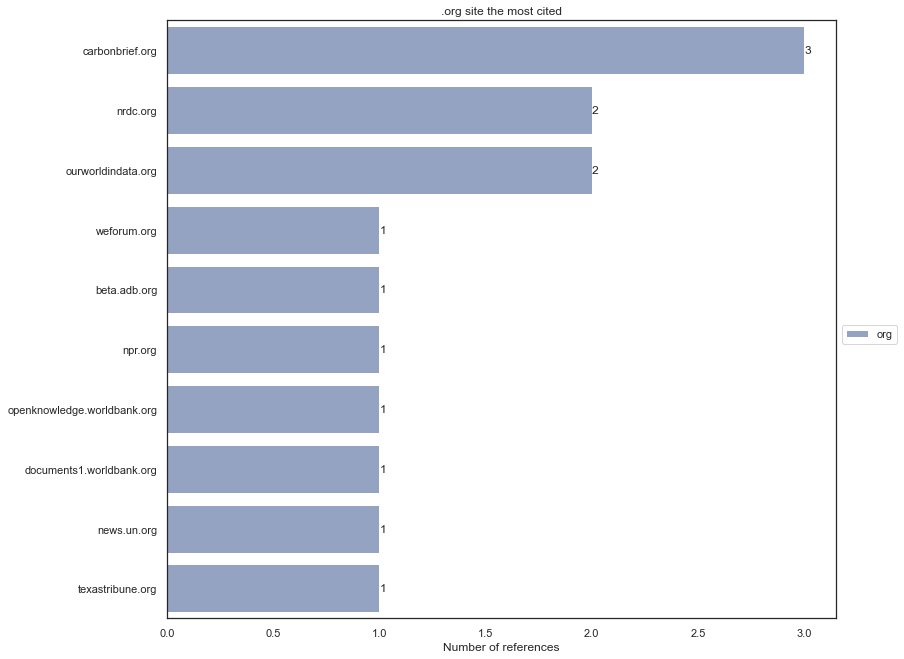

In [51]:
#An example of the plot for .org citation
dorg,dico=sortcitation(df.loc[:,"citationorgtext"],"org")    
plot_site_most_cited(dorg,10,".org site the most cited")

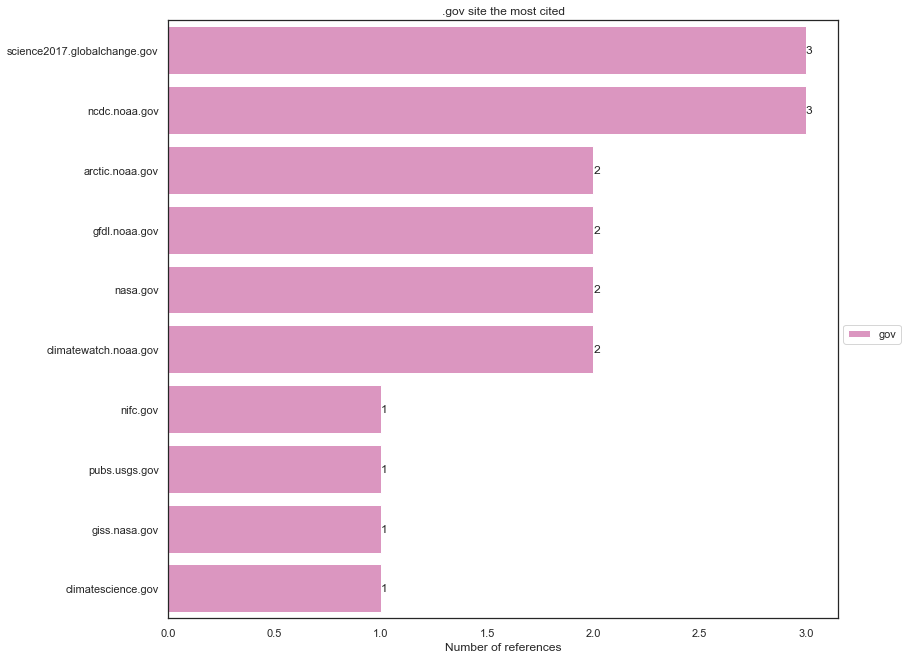

In [52]:
dfgov,j=sortcitation(df.loc[:,"citationgovtext"],"gov")
plot_site_most_cited(dfgov,10,".gov site the most cited")

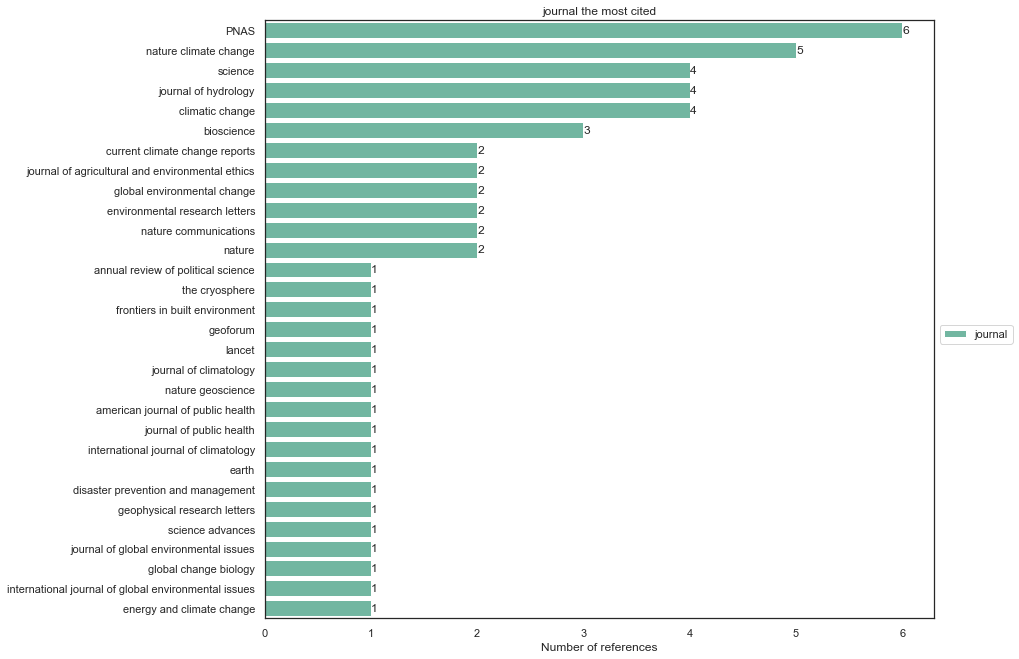

In [53]:
dfsci,j=sortcitation(df.loc[:,"journal"],"journal")
dfsci.loc[dfsci["name of site"]=="bioscience","number of times cited"]+=2
dfsci.sort_values(by=['number of times cited'], inplace=True, ascending=False)
plot_site_most_cited(dfsci,30, "journal the most cited")

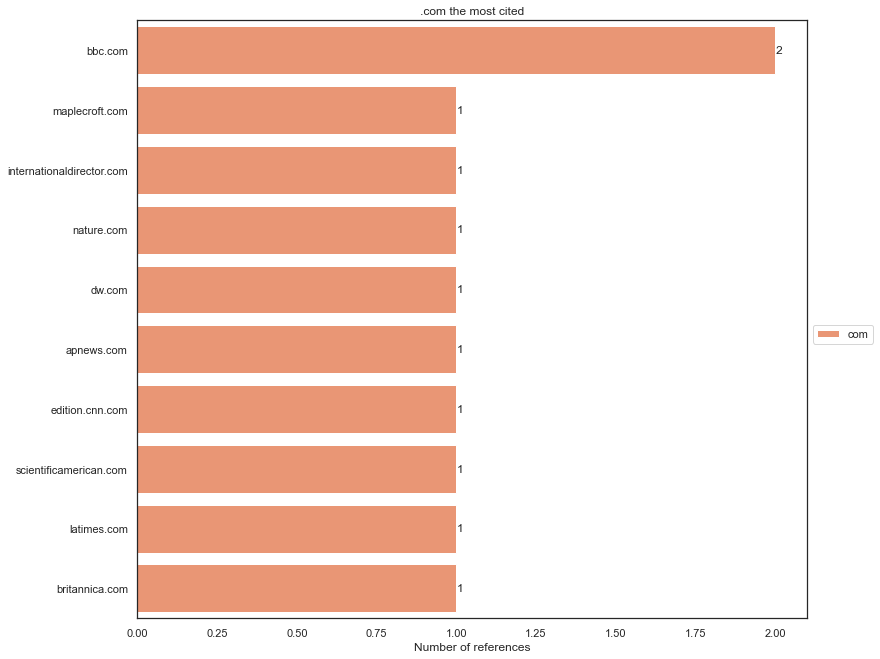

In [54]:
dcom,bl=sortcitation(df.loc[:,"citationcomtext"],"com")
plot_site_most_cited(dcom,10, ".com the most cited")

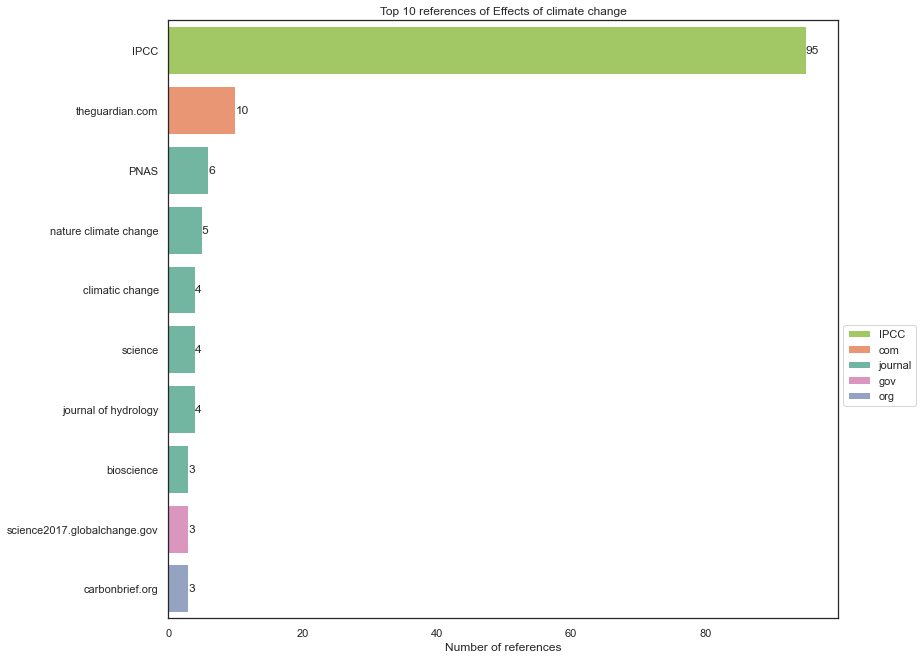

In [55]:
dIg={"name of site": ["IPCC","theguardian.com","biosciences"], "number of times cited":[df.loc[:,"citation IPCC"].sum(), df.loc[:,"citationguardian"].sum(),2], "type": ["IPCC","com","journal"]}
dIg = pd.DataFrame.from_dict(dIg)
big_df = pd.concat([dorg, dfgov,dcom,dfsci,dIg], ignore_index=True)
big_df.sort_values(by=['number of times cited'], inplace=True, ascending=False)
plot_site_most_cited(big_df,10,"Top 10 references of Effects of climate change")

## Cleaning the column and exporting the data frame and scrap of page information

In [56]:
titlelist=df["Name only"].tolist() #make a list will all titles
#We need to recreate the wiki url, first step is to get rid of blanks
titleunderscore = [sub.replace(' ', '_') for sub in titlelist]

In [57]:
#We finally get from the original url to the pageinfo url
urlmodifié = ['https://en.wikipedia.org/w/index.php?title=' + i +'&action=info' for i in titleunderscore]

In [58]:
#Cell to scrap infos from "page info" section (2 to scrap the third table of the page)
doblist=[]
creatorlist=[]
totaledits=[]
recentedits=[]
pageid=[]
pagelenght=[]
editprotection=[]
recentpageviews=[]

for i in tqdm(urlmodifié) :
    source = requests.get(i)
    soup = BeautifulSoup(source.text, 'lxml')
    alltables=soup.findAll('table', {"class": "wikitable mw-page-info"})
    tableau_html_liste=pd.read_html(str(alltables)) #We get it as a list   
    df_pageinfo2=pd.DataFrame(tableau_html_liste[2]) #And make it a df 
    #The number between brackets corresponds to the number of the table according to its order on the html page
    creatorlist += [df_pageinfo2.iat[0, 1]]
    doblist += [df_pageinfo2.iat[1, 1]]
    totaledits += [df_pageinfo2.iat[4, 1]]
    recentedits += [df_pageinfo2.iat[5, 1]]
    
    
    #Scrap of the first table of the page (0)
    df_pageinfo0=pd.DataFrame(tableau_html_liste[0])
    pagelenght += [df_pageinfo0.iat[2, 1]]
    pageid += [df_pageinfo0.iat[3, 1]]
            
    
    #Scrap of the second table of the page (1)
    df_pageinfo1=pd.DataFrame(tableau_html_liste[1])
    editprotection += [df_pageinfo1.iat[1, 1]]
  

    

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:22<00:00, 22.01s/it]


In [59]:
#Cell to add the new lists as new columns of the df
df["Page id"]=pageid
df["Edit protection"]=editprotection
df["Page lenght (Bytes)"]=pagelenght
df["DOB"]=doblist
df["Creator"]=creatorlist
df["Total edits"]=totaledits
df["Recent edits"]=recentedits
df.head()

,Name only,page url,text,citations,Ref count,nb_journal_citations,journalcitation,journal,nbjournaldetected,access,...,Sci count,IPCC count,percentage of official sources,Page id,Edit protection,Page lenght (Bytes),DOB,Creator,Total edits,Recent edits
0,Effects of climate change,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|Effects created by climate...,"{'Ref count': 252, 'journal_count': 55, 'nb_jo...",252,58,"[10.1073/pnas.1910114117, 10.1126/science.240....",[[proceedings of the national academy of scien...,55,[[proceedings of the national academy of scien...,...,0.230159,0.376984,0.81746,2119174,Require autoconfirmed or confirmed access (no ...,186484,"15:09, 26 June 2005",Rd232 (talk | contribs),5539,11


In [60]:
#Cleaning the table

#Getting rid of the time
df["DOB"]= df["DOB"].str.slice(7,100,1) 
#peutêtre qu'on pourrait mettre comme end point la len de la string

#Format the date
df["Formated DOB"]=pd.to_datetime(df["DOB"], format='%d %B %Y')
df["Year_month"]= pd.to_datetime(df['DOB']).dt.to_period('M')

#Getting the year
df['Year'] = pd.DatetimeIndex(df['DOB']).year

#Cleaning the creator 
df["Creator"]= df["Creator"].str.replace(r"\(.*\)",'', regex=True)

In [61]:
df

,Name only,page url,text,citations,Ref count,nb_journal_citations,journalcitation,journal,nbjournaldetected,access,...,Page id,Edit protection,Page lenght (Bytes),DOB,Creator,Total edits,Recent edits,Formated DOB,Year_month,Year
0,Effects of climate change,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|Effects created by climate...,"{'Ref count': 252, 'journal_count': 55, 'nb_jo...",252,58,"[10.1073/pnas.1910114117, 10.1126/science.240....",[[proceedings of the national academy of scien...,55,[[proceedings of the national academy of scien...,...,2119174,Require autoconfirmed or confirmed access (no ...,186484,26 June 2005,Rd232,5539,11,2005-06-26,2005-06,2005


#### Plot the ratio of page created by a certain editor in our corpus

#### plot of the timeline

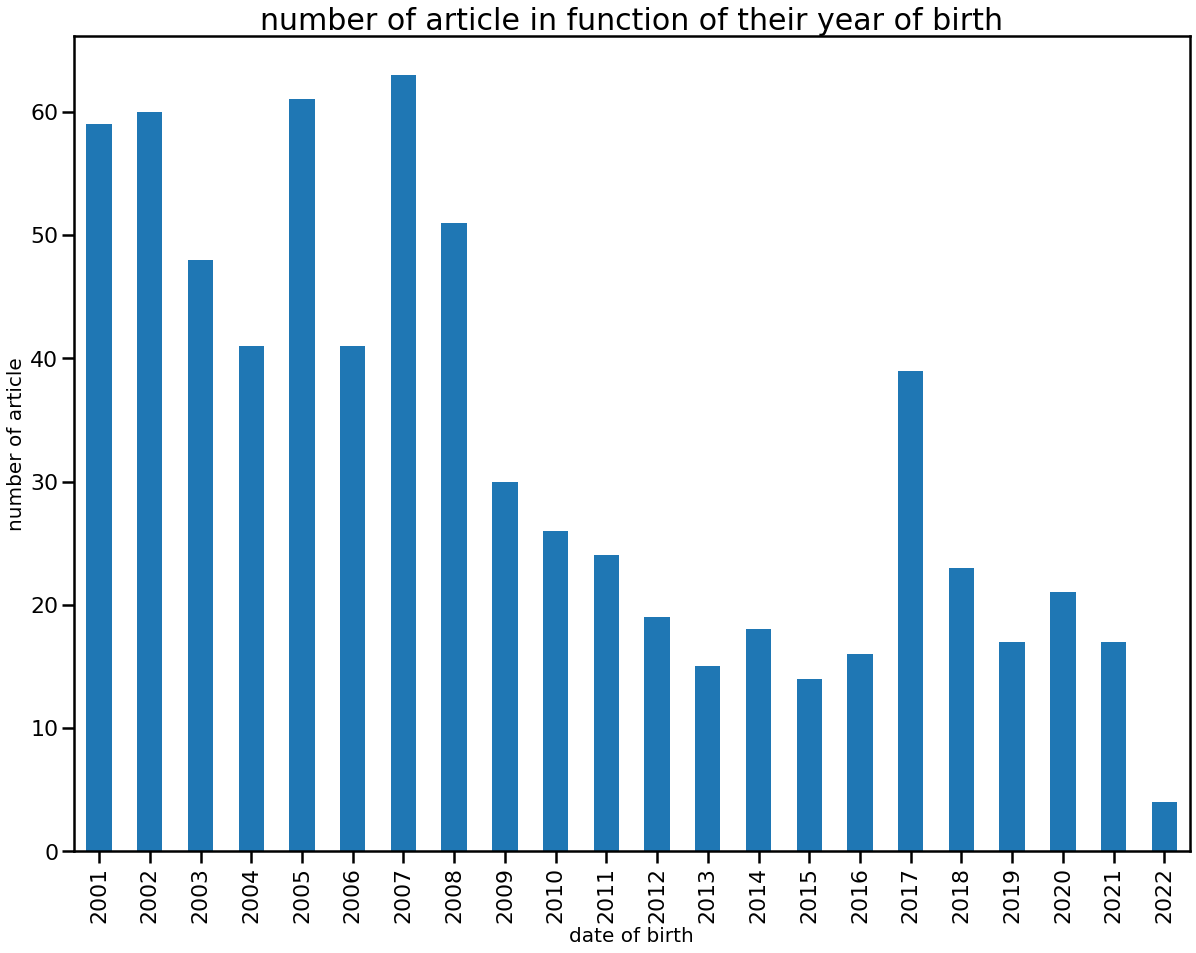

In [162]:
fig = plt.figure(0,figsize=(20,15))
plothist=df["Year"].value_counts().sort_index().plot(kind="bar")
fig.savefig('timeline.jpg', bbox_inches='tight', dpi=150)
plt.xlabel('date of birth',fontsize = 20) 
plt.ylabel('number of article',fontsize = 20) 
plt.title("number of article in function of their year of birth",fontsize = 30)
plt.show()

#### Clean and export the dataframes to csv

In [179]:
del df['citationorgtext']
del df['citationgovtext']
del df['text']
del df["citations"]
del df["citationcomtext"]

In [345]:
#extract the data frame to csv
df.to_csv('climatechange.csv')

"\ndorg.to_csv('CRISPR.csv')\ndfgov.to_csv('CRISPR.csv')\ndcom.to_csv('CRISPR.csv')"